In [1]:
#dataset and dataloader 
#더 나은 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적이다.

In [4]:
# 데이터셋 불러오기 MNIST
# 60,000 학습 예제, 10,000 테스트 예제
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = datasets.FashionMNIST(
    root="data", # 학습/테스트 데이터가 저장되는 경로
    train=True, # 학습용 또는 테스트용 데이터셋 여부를 지정
    download=True, # 데이터가 없는 경우 인터넷에서 다운로드
    transform=ToTensor(), #  특징(feature)과 정답(label) 변형(transform)을 지정
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



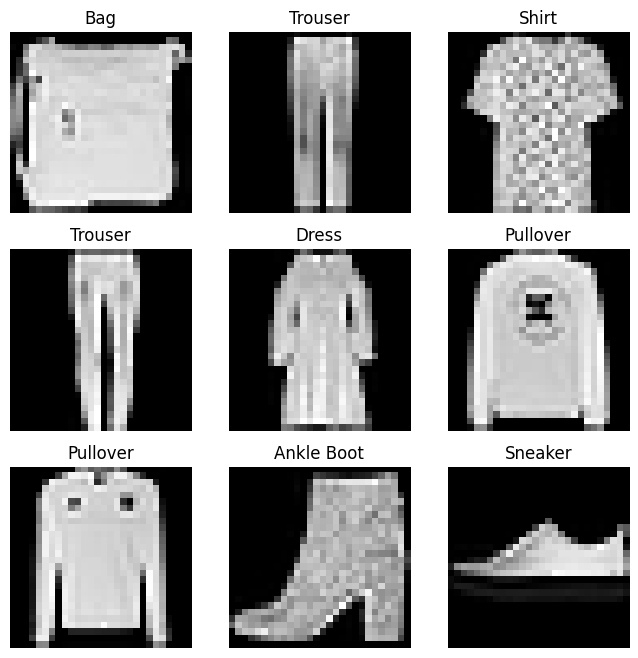

In [10]:
# 데이터셋을 순회하고 시각화하자
labels_map={
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure=plt.figure(figsize=(8,8))
cols,rows=3,3
for i in range(1, cols*rows+1):
    sample_idx=torch.randint(len(train_data),size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap="gray")
plt.show()

In [16]:
# 파일에서 사용자 정의 데이터셋 만들기
# 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 한다: __init__, __len__, and __getitem__.
# 아래 코드에서는 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은
# annotations_file csv 파일에 별도로 저장된다.
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    # Dataset 객체가 생성 될 때 한번만 실행된다.
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file,names=['file_name','label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # 데이터셋의 샘플 개수를 반환한다.
    def __len__(self):
        return len(self.img_labels)

    # 주어진 인덱스 idx 에 해당하는 샘플을 데이터셋에서 불러오고 반환한다.
    # idx -> 디스크에서 이미지의 위치 식별 -> read_image를 사용하여 이미지를 텐서로 변환
    # elf.img_labels 의 csv 데이터로부터 해당하는 정답(label)을 가져오고, 
    # (해당하는 경우)변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환
    def __getitem(self,idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx,1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return image, label

In [17]:
# Dataloader로 학습용 데이터 준비하기
# Dataset은 데이터셋의 feature을 가져오고, 하나의 샘플에 label을 지정하는 일을 한 번에 한다.
# 모델을 학습할 떼, 일반적으로 샘플들을 miniabatch로 전달, 매 epoch마다 데이터를 다시 섞어서
# 과적합을 막고, Python의 multiprocessing을 사용하여 데이터 검색 속도를 높이려고 한다.

# Dataloader는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)이다.

from torch.utils.data import DataLoader

train_dataloader=DataLoader(train_data, batch_size=64,shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=64,shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


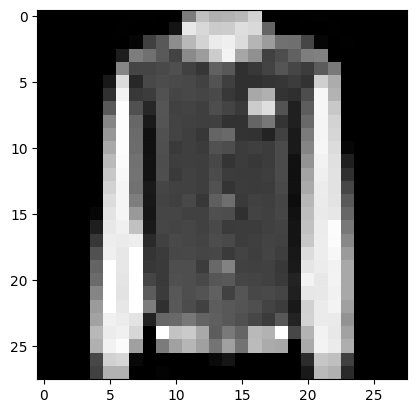

Label : 4


In [26]:
# DataLoader를 통해 순회하기
# DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회할 수 있다.
# 아래의 각 순회는 (각각 batch_size=64 의 특징(feature)과 정답(label)을 포함하는) 
# train_features 와 train_labels 의 묶음(batch)을 반환.
# shuffle=True 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞인다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img=train_features[0].squeeze()
label=train_labels[0]
plt.imshow(img,cmap='gray')
plt.show()
print(f"Label : {label}")
#torch.Size([64, 1, 28, 28])은 64개의 이미지가 각각 1채널, 28x28 크기의 흑백 이미지임을 나타낸다.
# Labels batch shape: torch.Size([64]): 이 부분은 레이블(타겟 값)의 배치를 설명한다. 
# torch.Size([64])는 1차원 텐서이다.
# 첫 번째 차원(64): 배치 크기가 64임을 나타냅니다. 따라서 이 배치에는 64개의 레이블 값이 있다.

In [27]:
# 배치(batch)는 딥러닝에서 데이터를 작은 그룹으로 나누어 모델을 훈련하는 방식을 말한다. 
# 예를 들어, 전체 데이터셋을 100개씩의 이미지로 나누어 한 번에 처리할 수 있다. 
# 배치 크기(batch size)는 각 배치에 포함되는 데이터의 개수를 나타내며, 
# 이는 메모리 사용과 학습 속도에 영향을 미친다. 
# 작은 배치를 사용하면 계산 효율성을 높아짐, 메모리 효율성 높음
# 하지만 큰 배치를 사용하는것이 일반적으로 더 좋은 일반화 성능
# 수렴속도도 고려해야

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `[딥러닝 이미지](https://example.com/deep-learning.png)'
